In [90]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm import tqdm
import timm
import numpy as np
import random
from torch.utils.data import random_split
import torch.nn.functional as F
import pickle
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
from sklearn.manifold import TSNE

In [3]:
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(1536, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, input1, input2):
        combined_features = input1 * input2

        return self.fc(combined_features)

In [4]:
class FeatureModel(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(FeatureModel, self).__init__()

        # Load a pretrained resnet model from torchvision.models in Pytorch
        self.model = timm.create_model('inception_resnet_v2', pretrained=False)

        # Change the input layer to take Grayscale image, instead of RGB images.
        # Hence in_channels is set as 1 or 3 respectively
        # original definition of the first layer
        # self.conv1 = Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        self.model.conv2d_1a.conv = nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, bias=False)

        # Change the output layer to output 10 classes instead of 1000 classes
        num_ftrs = self.model.classif.in_features
        self.model.classif = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

In [47]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [5]:
transform = transforms.Compose([
    transforms.Resize(139),  # minimum image size for inception resnet
    transforms.ToTensor(),
])

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

train_len = int(0.8 * len(training_data))
val_len = len(training_data) - train_len
torch.manual_seed(42)
train_data, val_data = random_split(training_data, [train_len, val_len])

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = SiameseNetwork()
model.load_state_dict(torch.load('results/siamese/model12.pth'))
model = model.to(device)
model.eval()

feature_model = FeatureModel()
feature_model.load_state_dict(torch.load('results/classifier/model19.pth'))
feature_model.model.classif = nn.Identity()
feature_model.to(device)
feature_model.eval()

In [9]:
test_data[0], test_data[1]

((tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  9),
 (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  2))

In [23]:
img0 = test_data[1][0]
img1 = test_data[1][0]

img0 = img0.unsqueeze(1)
img1 = img1.unsqueeze(1)

img0 = img0.to(device)
img1 = img1.to(device)

img0 = feature_model(img0)
img1 = feature_model(img1)

model(img0, img1)[0].item(), test_data[1][1], test_data[1][1]

(0.0020658730063587427, 2, 2)

In [35]:
def find_similar(img0, dataset):
    res = []
    
    img0 = img0.unsqueeze(1)
    img0 = img0.to(device)
    img0 = feature_model(img0)
    
    for i in tqdm(range(len(dataset))):
        img1 = dataset[i][0]
        img1 = img1.unsqueeze(1)
        img1 = img1.to(device)
        img1 = feature_model(img1)
        
        res.append(model(img0, img1)[0].item())
        
    return res

In [77]:
indices = torch.arange(0, 1000)
test_data_sub = data_utils.Subset(test_data, indices)

similar = find_similar(test_data[0][0], test_data_sub)

100%|██████████| 1000/1000 [00:51<00:00, 19.35it/s]


In [78]:
max_similar = np.argpartition(similar, 5)[:5]
max_similar

array([644, 780, 810, 940, 709], dtype=int64)

In [79]:
[test_data_sub[i][1] for i in max_similar]

[9, 9, 9, 9, 9]

In [80]:
min_similar = np.argpartition(similar, -5)[-5:]
min_similar

array([724, 110, 758, 301, 197], dtype=int64)

In [81]:
[test_data_sub[i][1] for i in min_similar]

[6, 2, 6, 3, 3]

In [51]:
min_similar = np.argpartition(similar, -5)[:5]
min_similar

array([74,  0,  2,  3,  4], dtype=int64)

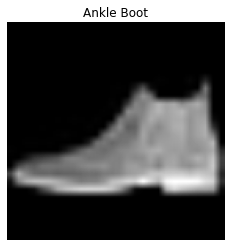

In [82]:
plt.imshow(test_data[0][0].squeeze(), cmap="gray")
plt.title(labels_map[test_data[0][1]])
plt.axis("off")
plt.show()

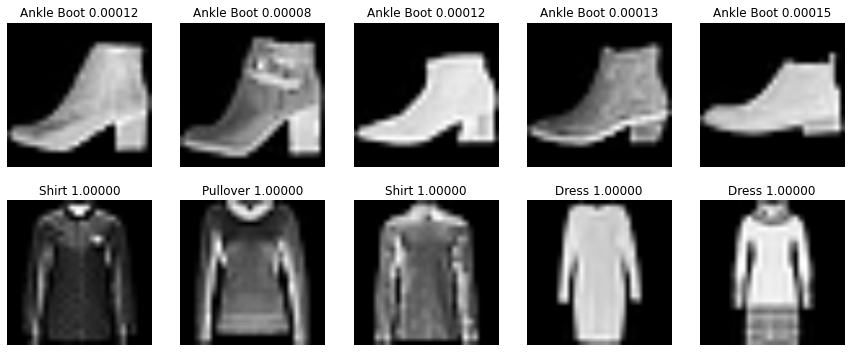

In [85]:
figure = plt.figure(figsize=(15, 6))
cols, rows = 5, 2

for i in range(1, cols * rows + 1):
    if i < 6:
        sample_idx = max_similar[i - 1]
    else:
        sample_idx = min_similar[i - 6]
        
    img, label = test_data_sub[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'{labels_map[label]} {similar[sample_idx]:.5f}')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [86]:
with open('test.pickle', 'rb') as f:
    data = pickle.load(f)

In [91]:
test_features = [el[0].numpy() for el in data]

In [96]:
y_test = [el[1].item() for el in data]

In [92]:
tsne = TSNE(n_components=2, init='pca', random_state=42, method='barnes_hut', n_iter=500, verbose=2)
tsne_features = tsne.fit_transform(test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.015s...
[t-SNE] Computed neighbors for 10000 samples in 3.248s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.422302
[t-SNE] Computed conditional probabilities in 0.297s
[t-SNE] Iteration 50: error = 74.0434952, gradient norm = 0.0045379 (50 iterations in 1.814s)
[t-SNE] It

In [106]:
obj_categories

['T-Shirt',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle Boot']

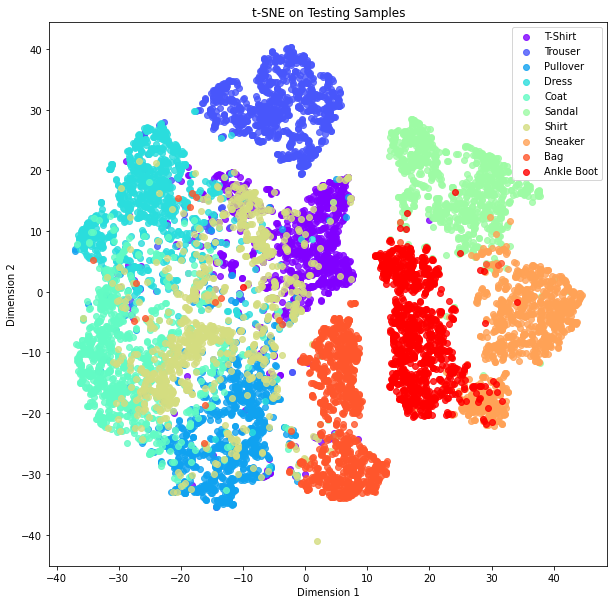

In [111]:
obj_categories = list(labels_map.values())
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(np.array(y_test) == c_group), 0], tsne_features[np.where(np.array(y_test) == c_group), 1], 
                marker='o', color=c_color, linewidth=1, alpha=0.8, label=c_label)
    
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.show(block=False)